In [6]:
import numpy as np
import pandas as pd

import numpyro
import numpyro.distributions as dist
from numpyro.infer import MCMC, NUTS
import jax.numpy as jnp
import jax.random as random
import jax.nn as nn


# Hybrid Bayesian CLV Estimation Code

This contains the code for the models in the Strata IQ Blog Post titled "Hybrid Bayesian CLV Estimation Code".

We first generate synthetic data in a separate notebook.  This notebook focuses on the model building and assessing error 
and efficacy of the models.

In [7]:
# Read in Synthetically Generated Data
df = pd.read_csv( "Data/syn_clv_dataset_blog.csv" )      # regenerated a version of the original data set that had good results
print( df.describe() )
df.head( 36 )

       customer_id         week       emails          ads      churned  \
count  1200.000000  1200.000000  1200.000000  1200.000000  1200.000000   
mean     49.500000     5.500000     0.644167     1.089167     1.195833   
std      28.878105     3.453492     1.106151     1.608842     0.941570   
min       0.000000     0.000000     0.000000     0.000000     0.000000   
25%      24.750000     2.750000     0.000000     0.000000     0.000000   
50%      49.500000     5.500000     0.000000     0.000000     2.000000   
75%      74.250000     8.250000     1.000000     2.000000     2.000000   
max      99.000000    11.000000     6.000000    10.000000     2.000000   

          purchase          eff      ch_prob         demo       region  \
count   1200.00000  1200.000000  1200.000000  1200.000000  1200.000000   
mean     920.33500     0.254691     0.316376     0.430000     0.980000   
std     1851.85778     0.559328     0.336904     0.495282     0.824722   
min        0.00000    -2.386837     0

,customer_id,week,emails,ads,churned,purchase,eff,ch_prob,demo,region,time_to_churn,censored,churn_week
0,0,0,2,1,0,19,0.000000,0.377541,0,2,0,0,8
1,0,1,0,3,0,1535,1.534718,0.012910,0,2,7,0,8
2,0,2,2,3,0,1801,1.489210,0.014443,0,2,6,0,8
3,0,3,0,2,0,3251,1.033640,0.043768,0,2,5,0,8
4,0,4,1,0,0,5129,1.088516,0.038372,0,2,4,0,8
5,0,5,3,3,0,2147,1.428300,0.016778,0,2,3,0,8
6,0,6,1,2,0,1510,0.494968,0.149641,0,2,2,0,8
7,0,7,0,3,0,2661,0.548708,0.133337,0,2,1,0,8
8,0,8,1,1,1,2957,0.547944,0.133558,0,2,0,0,8
9,0,9,0,0,2,0,0.000000,0.064288,0,2,0,0,8


In [8]:
# 
def adstock(x, decay):
    """Exponential adstock function."""
    result = []
    prev = jnp.zeros_like(x[:, 0])
    for t in range(x.shape[1]):
        prev = x[:, t] + decay * prev
        result.append(prev)
    return jnp.stack(result, axis=1)


# 
def weibull_clv_model_continuous_v3(
    churn_week,
    churn_observed,
    email,
    ad,
    region,
    n_region_categories,
    demo,
    n_demo_categories
):
    n_customers, n_weeks = email.shape

    # Priors for covariate-driven alpha (shape parameter)
    alpha_intercept = numpyro.sample("alpha_intercept", dist.Normal(0, 1))
    alpha_region_effect = numpyro.sample("alpha_region_effect", dist.Normal(0, 1).expand([n_region_categories]))
    alpha_demo_effect   = numpyro.sample("alpha_demo_effect", dist.Normal(0, 1).expand([n_demo_categories]))
    alpha_email_effect  = numpyro.sample("alpha_email_effect", dist.Normal(0, 1))
    alpha_ad_effect     = numpyro.sample("alpha_ad_effect", dist.Normal(0, 1))
    alpha_delta         = numpyro.sample("alpha_delta", dist.HalfNormal(0.1))


    #
    # PARAMETERS FOR "K"
    #
    region_effect = numpyro.sample("region_effect", dist.Normal(0, 0.5).expand([n_region_categories]))
    demo_effect = numpyro.sample("demo_effect", dist.Normal(0, 0.5).expand([n_demo_categories]))

    # Priors for dynamic covariates (exposure)
    email_effect = numpyro.sample("email_effect", dist.Normal(0, 1))
    ad_effect = numpyro.sample("ad_effect", dist.Normal(0, 1))

    # Sample decay parameters
    email_decay = numpyro.sample("email_decay", dist.Beta(2, 2))
    ad_decay = numpyro.sample("ad_decay", dist.Beta(2, 2))
    
    # Apply adstock transformation
    email_adstocked = adstock(email, email_decay)
    ad_adstocked = adstock(ad, ad_decay)

    total_email_exposure = jnp.sum(email_adstocked, axis=1)     # (100,)
    total_ad_exposure    = jnp.sum(ad_adstocked, axis=1)        # (100,)

    # over exposure parameter
    delta = numpyro.sample("delta", dist.HalfNormal(0.1))
    total_exposure = total_email_exposure + total_ad_exposure
    
    # Compute log_lambda using adstocked exposures
    log_lambda = (
        region_effect[region] +
        demo_effect[demo] +
        email_effect * total_email_exposure +
        ad_effect * total_ad_exposure - 
        delta * total_exposure ** 2
    )

    lambda_ = jnp.exp(jnp.clip(log_lambda, -2.0, 4.0))
    
    # log lambda in the trace
    numpyro.deterministic( "lambda_", lambda_ )

    # Compute alpha per customer
    log_alpha = (
        alpha_intercept +
        alpha_region_effect[region] +
        alpha_demo_effect[demo] +
        alpha_email_effect * total_email_exposure +
        alpha_ad_effect * total_ad_exposure -
        alpha_delta * total_exposure ** 2
    )
    
    alpha = jnp.exp( jnp.clip( log_alpha, -1.5, 1.5 ) ) # Prevent extreme values, Shape: (n_customers,) 
   
    numpyro.deterministic( "alpha", alpha )

    # 
    # This section models the likelihood in 2 parts, by leveraging Numpyro's Factor() method:
    # 1. Observered Churn Customers
    # 2. Censored Customers (where churn was not observed)
    with numpyro.plate("customers", n_customers):
        
        churn_week = jnp.clip(churn_week, a_min=1e-3)  # Avoid zero for stability

        # Observed churn: use Weibull likelihood
        numpyro.factor(
            "logp_observed",
            churn_observed * dist.Weibull( scale=lambda_, concentration=alpha ).log_prob( churn_week )
        )

        # Censored churn: use manually computed log survival function
        log_survival = -((churn_week / lambda_) ** alpha)
        numpyro.factor( "logp_censored", (1 - churn_observed) * log_survival )



In [9]:
#
# extract required data for Weibull model
#
df_grouped = df.groupby( 'customer_id' ).first().reset_index()
demo_arr = df_grouped['demo'].to_numpy()
region_arr = df_grouped['region'].to_numpy()

customer_id_list     = df['customer_id'].sort_values().unique()
churn_week_array     = np.ones( len(customer_id_list) )
churn_observed_array = np.zeros( len(customer_id_list) )


# note: churn_week starts at 1, not zero
if ('churn_week' in df.columns) and ('churn_observed' in df.columns ):
    print( "INFO: churn_week already setup..." )
    churn_week_array     = df['churn_week'].values
    churn_observed_array = df['churn_observed'].values

else:

    # add the censored column and the time to churn column 
    df['censored']      = 0
    df['churn_week']    = 0
        
    WEEKS_PER_CUSTOMER = 12
    NUM_CENSORED = 0
    
    churn_week_array = (churn_week_array * WEEKS_PER_CUSTOMER)
    
    # loop over customers
    for id in customer_id_list:
        
        df_ss = df[ df['customer_id'] == id ]
        
        sum_churned = df_ss['churned'].sum()
        
        if sum_churned == 0:
            df.loc[ df['customer_id'] == id, 'censored' ] = 1
            NUM_CENSORED = NUM_CENSORED + 1
        else:
            # mark global array
            churn_observed_array[id] = 1
            churn_week = 0
            time_to_churn   = np.zeros( len( df_ss ) )
            churned_data_ss = df_ss['churned'].to_numpy()
            min_idx = WEEKS_PER_CUSTOMER * id 
            
            
            for idx in range(0,len(df_ss)):
                c_val = df_ss.iloc[ idx ]['churned']
                if c_val == 1:
                    churn_week = idx
                    # print( "c_week: ", churn_week, " | min idx: ", min_idx )
                    break
    
    
            # 
            df.loc[ df['customer_id'] == id, 'churn_week' ] = (churn_week + 1)
            churn_week_array[id] = (churn_week + 1)

    
    print( "NUM_CENSORED: ", NUM_CENSORED )    

NUM_CENSORED:  9


# Run MCMC sampling for Weibull model


In [10]:
import numpyro
from numpyro.infer import MCMC, NUTS
import jax
import jax.numpy as jnp

# Assume these are already prepared:
# churn_week: shape (n_customers,)
# churn_observed: shape (n_customers,)
# email, ad: shape (n_customers, n_weeks)
# region, demo: shape (n_customers,)

# Run MCMC
kernel = NUTS( weibull_clv_model_continuous_v3 )
mcmc = MCMC(kernel, num_warmup=1000, num_samples=2000, num_chains=2)
rng_key = jax.random.PRNGKey(0)


n_customers = df["customer_id"].nunique()
n_weeks = df["week"].nunique()

#
b_churn_observed_array = churn_observed_array.astype(bool)
print( "bchurn: ", b_churn_observed_array )

# 
mcmc.run(
    rng_key,
    churn_week=churn_week_array,
    churn_observed=b_churn_observed_array,
    email=np.reshape( df['emails'].to_numpy(), (n_customers, n_weeks) ),
    ad=np.reshape( df['ads'].to_numpy(), (n_customers, n_weeks) ),
    region=region_arr,
    n_region_categories=len(np.unique(region_arr)),
    demo=demo_arr,
    n_demo_categories=len(np.unique(demo_arr))
)

mcmc.print_summary()
posterior_samples = mcmc.get_samples()

for k in posterior_samples.keys():
    print( "key: ", k, " -> ", jnp.shape( posterior_samples[k] ) )



/var/folders/m9/dl7djppj5jg_h_txwcx_rvmw0000gn/T/ipykernel_29427/2233014220.py:14: UserWarning: There are not enough devices to run parallel chains: expected 2 but got 1. Chains will be drawn sequentially. If you are running MCMC in CPU, consider using `numpyro.set_host_device_count(2)` at the beginning of your program. You can double-check how many devices are available in your system using `jax.local_device_count()`.
  mcmc = MCMC(kernel, num_warmup=1000, num_samples=2000, num_chains=2)


bchurn:  [ True  True  True  True  True  True  True  True  True  True  True  True
  True  True  True  True  True  True  True  True  True  True  True False
  True  True  True  True  True False  True  True  True  True  True  True
  True  True  True  True  True  True  True  True  True  True  True  True
  True False  True  True  True  True False  True  True  True False False
  True  True  True  True  True  True  True  True  True  True False  True
  True  True  True  True  True  True  True  True  True  True  True  True
  True  True  True  True  True  True  True  True  True  True  True  True
  True False False  True]


sample: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 3000/3000 [01:29<00:00, 33.55it/s, 255 steps of size 1.75e-02. acc. prob=0.80]



                            mean       std    median      5.0%     95.0%     n_eff     r_hat
              ad_decay      0.15      0.09      0.14      0.02      0.29   1827.98      1.00
             ad_effect      0.08      0.01      0.08      0.07      0.10   1716.24      1.00
       alpha_ad_effect      0.87      0.73      0.75     -0.23      1.94   1034.59      1.00
           alpha_delta      0.01      0.01      0.01      0.00      0.02   1903.87      1.00
  alpha_demo_effect[0]      0.34      0.87      0.34     -1.11      1.72   3496.56      1.00
  alpha_demo_effect[1]      0.36      0.87      0.37     -0.99      1.83   2937.95      1.00
    alpha_email_effect      1.16      0.70      1.13     -0.01      2.24   1993.62      1.00
       alpha_intercept      0.71      0.85      0.70     -0.67      2.07   2674.13      1.00
alpha_region_effect[0]      0.27      0.89      0.26     -1.30      1.66   3340.26      1.00
alpha_region_effect[1]     -0.13      0.94     -0.15     -1.69      1

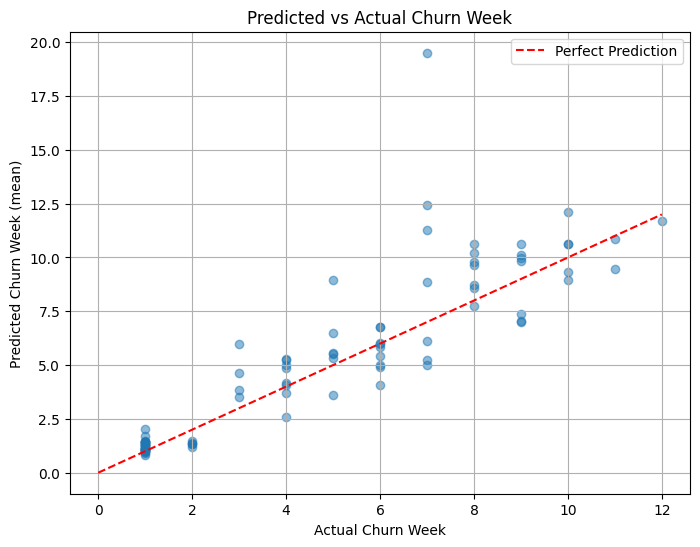

In [11]:
import arviz as az
import numpy as np
import matplotlib.pyplot as plt


idata = az.from_numpyro( mcmc )

# Sample posterior predictive churn times
lambda_post = idata.posterior["lambda_"].values.reshape(-1, n_customers)
alpha_post = idata.posterior["alpha"].values.reshape(-1, n_customers)    # shape (samples, 1)

# Inverse CDF sampling (Monte Carlo): Weibull time-to-event
rng = np.random.default_rng(0)
u = rng.uniform( size=lambda_post.shape )
predicted_weeks = lambda_post * (-np.log(1 - u)) ** (1 / alpha_post)

# Average prediction for each customer
predicted_weeks_mean = predicted_weeks.mean( axis=0 )

# Only include users with observed churn
mask = b_churn_observed_array == 1
actual_weeks = churn_week_array[ mask ]
predicted_weeks_eval = predicted_weeks_mean[ mask ]

# Scatter plot
plt.figure(figsize=(8, 6))
plt.scatter(actual_weeks, predicted_weeks_eval, alpha=0.5)
plt.plot([0, 12], [0, 12], 'r--', label="Perfect Prediction")
plt.xlabel("Actual Churn Week")
plt.ylabel("Predicted Churn Week (mean)")
plt.title("Predicted vs Actual Churn Week")
plt.legend()
plt.grid(True)
plt.show()

In [12]:
# compute metrics
from sklearn.metrics import mean_squared_error
from sklearn.metrics import root_mean_squared_error

rmse = root_mean_squared_error( actual_weeks, predicted_weeks_eval )
ape  = np.abs(actual_weeks - predicted_weeks_eval) / actual_weeks
mape = np.mean( ape )

print( "simulation accuracy results: ", rmse, " ", mape )

simulation accuracy results:  1.8531625183886171   0.2493284777604819


# Build the Spend Model - with Co-Variates
Leverage Demo & Region to help predict the spend per user.


In [13]:
# Prepare the Covariates Matrix
import pandas as pd
import numpy as np

# One-hot encode region
region_dummies = pd.get_dummies(df['region'], prefix='region', drop_first=True)

# Stack with demo
X_churn = np.column_stack([
    df['demo'].values.reshape(-1, 1),
    region_dummies.values  # e.g., two columns if region has 3 categories
])

df_churn = pd.DataFrame( X_churn )

In [14]:
#
# HYBRID model specification
#
import numpyro
import numpyro.distributions as dist
import jax.numpy as jnp

def hybrid_model_reparm(
    y_churn, y_purchase,
    user_ids, week_ids,
    is_churn_obs, is_purchase_obs,
    X_churn,  # covariates for churn [N, K]
    n_users, n_weeks
):
    K = X_churn.shape[1]

    # --- Churn component with reparameterized alpha_c ---
    mu_alpha_c = numpyro.sample("mu_alpha_c", dist.Normal(0., 1.))
    sigma_alpha_c = numpyro.sample("sigma_alpha_c", dist.Exponential(0.3))

    alpha_c_raw = numpyro.sample("alpha_c_raw", dist.Normal(0., 1.).expand([n_users]))
    alpha_c = mu_alpha_c + sigma_alpha_c * alpha_c_raw

    sigma_beta_c = numpyro.sample("sigma_beta_c", dist.Exponential(1.0))
    beta_c = numpyro.sample("beta_c", dist.Normal(0., sigma_beta_c).expand([n_weeks]))

    # Coefficients for churn covariates
    w_c = numpyro.sample("w_c", dist.Normal(0., 1.).expand([K]))

    churn_logits = (
        alpha_c[user_ids] +
        beta_c[week_ids] +
        jnp.dot(X_churn, w_c)
    )
    p_churn = jnp.clip(jax.nn.sigmoid(churn_logits), 1e-6, 1 - 1e-6)

    numpyro.sample(
        "obs_churn",
        dist.Bernoulli(probs=p_churn[is_churn_obs]),
        obs=y_churn[is_churn_obs]
    )

    # --- Purchase component (unchanged) ---
    intercept_mean = np.log( np.mean(y_purchase) )
    mu_alpha_p = numpyro.sample("mu_alpha_p", dist.Normal( intercept_mean, 2 ))

    # sigma_alpha_p = numpyro.sample("sigma_alpha_p", dist.Exponential(1.0))
    # mu_alpha_p = numpyro.sample("mu_alpha_p", dist.Normal(0.0, 2.0))          # new
    #sigma_alpha_p = numpyro.sample("sigma_alpha_p", dist.HalfCauchy(2.0))     # new
    # alpha_p = numpyro.sample("alpha_p", dist.Normal(mu_alpha_p, sigma_alpha_p).expand([n_users]))
    # Non-centered user-level effects
    alpha_p_user_raw = numpyro.sample("alpha_p_user_raw", dist.Normal(0.0, 2.0).expand([n_users]))
    alpha_p_user = alpha_p_user_raw    

    sigma_beta_p = numpyro.sample("sigma_beta_p", dist.Exponential(1.0))
    beta_p = numpyro.sample("beta_p", dist.Normal(0., sigma_beta_p).expand([n_weeks]))

    # Coefficients for churn covariates
    w_p = numpyro.sample( "w_p", dist.Normal(0., 0.5).expand([K]) )
    purchase_mean  = mu_alpha_p + alpha_p_user[user_ids] + beta_p[week_ids] + jnp.dot(X_churn, w_p)

    # purchase_mean  = alpha_p_user[user_ids] + beta_p[week_ids] 
    # sigma_purchase = numpyro.sample("sigma_purchase", dist.Exponential(0.25))
    sigma_purchase = numpyro.sample("sigma_purchase", dist.HalfCauchy(0.1))

    purchase_loc = purchase_mean[ is_purchase_obs.values ]

    numpyro.sample(
        "obs_purchase",
        dist.LogNormal(loc=purchase_loc, scale=sigma_purchase),   # dist.LogNormal(loc=purchase_loc, scale=sigma_purchase),
        obs=y_purchase[is_purchase_obs]
    )


In [15]:
# data prep
# Map user ids to integer indices
user_id_map = {uid: i for i, uid in enumerate(df['customer_id'].unique())}
df['user_idx'] = df['customer_id'].map(user_id_map)

# Sort by user/week
df = df.sort_values(['user_idx', 'week'])

# Extract arrays
user_ids = df['user_idx'].values
week_ids = df['week'].values.astype(int)
n_users = df['user_idx'].nunique()
n_weeks = df['week'].nunique()

# Churn target (binary): 1 = churned that week, 0 = not churned, ignore 2s in likelihood
is_churn_obs = df['churned'].isin([0, 1]).values
y_churn = df['churned'].replace({2: 0}).values  # we will mask out 2s later

# Purchase target: only use where churn_flag != 2
y_purchase = df['purchase'].values
is_purchase_obs = df['churned'] != 2

In [16]:
# Run MCMC
nuts_kernel = NUTS( hybrid_model_reparm )
mcmc = MCMC( nuts_kernel, num_warmup=500, num_samples=1000, num_chains=2 )
mcmc.run(jax.random.PRNGKey(0),
         y_churn=y_churn,
         y_purchase=y_purchase,
         user_ids=user_ids,
         week_ids=week_ids,
         is_churn_obs=is_churn_obs,
         is_purchase_obs=is_purchase_obs,
         X_churn=X_churn,
         n_users=n_users,
         n_weeks=n_weeks)

mcmc.print_summary()

hybrid_samples = mcmc.get_samples() 

/var/folders/m9/dl7djppj5jg_h_txwcx_rvmw0000gn/T/ipykernel_29427/2661132991.py:3: UserWarning: There are not enough devices to run parallel chains: expected 2 but got 1. Chains will be drawn sequentially. If you are running MCMC in CPU, consider using `numpyro.set_host_device_count(2)` at the beginning of your program. You can double-check how many devices are available in your system using `jax.local_device_count()`.
  mcmc = MCMC( nuts_kernel, num_warmup=500, num_samples=1000, num_chains=2 )
sample: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1500/1500 [00:43<00:00, 34.66it/s, 31 steps of size 1.50e-01. acc. prob=0.90]



                          mean       std    median      5.0%     95.0%     n_eff     r_hat
      alpha_c_raw[0]     -0.30      0.85     -0.33     -1.70      1.11   2233.12      1.00
      alpha_c_raw[1]      0.09      0.89      0.10     -1.35      1.55   2923.15      1.00
      alpha_c_raw[2]      0.09      0.94      0.06     -1.39      1.64   3488.93      1.00
      alpha_c_raw[3]     -0.05      0.91     -0.05     -1.51      1.43   3491.27      1.00
      alpha_c_raw[4]     -0.06      0.91     -0.05     -1.47      1.50   4043.70      1.00
      alpha_c_raw[5]     -0.30      0.90     -0.35     -1.75      1.23   2618.47      1.00
      alpha_c_raw[6]      0.12      0.93      0.13     -1.38      1.66   4128.76      1.00
      alpha_c_raw[7]     -0.18      0.83     -0.21     -1.49      1.26   2420.16      1.00
      alpha_c_raw[8]      0.22      0.94      0.25     -1.28      1.81   4002.43      1.00
      alpha_c_raw[9]      0.32      0.98      0.31     -1.21      1.97   2638.11      1.0

In [19]:
#
# a computation from point estimates, derived from samples
#
def compute_clv(
    samples,
    n_users,
    n_weeks,
    user_churn_week,
    X,
    discount_rate=0.0
):
    """
    samples: dict from MCMC.get_samples()
    n_users: number of users
    n_weeks: number of weeks
    discount_rate: optional weekly discount rate
    """

    n_draws = samples['alpha_c_raw'].shape[0]
    clv_simulated = np.zeros( n_users )

    # pin the week down...
    # strategy is to either round or ceil the week.
    user_churn_week = np.round( user_churn_week ).astype( int )

    alpha_p_intercept = samples['mu_alpha_p']
    INTERCEPT = jnp.mean(alpha_p_intercept)
    print( "INTERCEPT: ", INTERCEPT )
    # alpha_p_scaler = samples['sigma_alpha_p'].T
    alpha_p = samples['alpha_p_user_raw'].T
    beta_p  = samples['beta_p'].T
    scale   = samples['sigma_purchase']
    scale_med = jnp.mean( scale )

    w_p        = samples['w_p'].T
    w_purchase = jnp.mean( w_p, axis=1 )
    print( "len w_purchase: ", len(w_purchase) )
    
    
    for u in range(n_users):

        clv = 0.0
        alive = True

        for t in range(n_weeks):
            
            # Randomly pick one posterior draw
            draw_idx = np.random.randint(n_draws)

            if alive and t == user_churn_week[u]:
                break # user churns this week

            # Purchase distribution: LogNormal
            loc = INTERCEPT + jnp.mean(alpha_p[u]) + jnp.mean( beta_p[t] ) + jnp.dot( X[u], w_purchase )

            # going off point estimates to minimize variance
            # purchase_amt = np.exp( loc + (0.5 * (scale_med**2)) )
            purchase_amt = np.exp( loc )

            # Discount and accumulate
            clv += purchase_amt / ((1 + discount_rate) ** t)



        clv_simulated[u] = clv

    # Take mean across simulations per user
    expected_clv = clv_simulated
    return expected_clv, clv_simulated


In [20]:
#
# now, the final step: estimate the spend for each customer
#
# first simple version: pass in the churn week W from the Weibull model
#   simulate spend draws going from (0, W)
#

# computing based off the point estimates 
expected_clv, _ = compute_clv( hybrid_samples, n_users, n_weeks, churn_week_array, X_churn )

INTERCEPT:  5.8796263
len w_purchase:  3


# Compare CLV against ground truth; compute error

In [21]:
# create ground truth by summing across rows
y_purchase_rshp = np.reshape( y_purchase, (100,12) )
clv_truth = np.sum( y_purchase_rshp, axis=1 )
clv_truth

# only look at customers with some type of significant CLV
pruned_clv_idx = clv_truth > 100 

clv_truth_filtered = clv_truth[ pruned_clv_idx ]

# compute ground truth
from sklearn.metrics import mean_squared_error
from sklearn.metrics import root_mean_squared_error

exp_clv_filtered      = expected_clv[ pruned_clv_idx ]

rmse = root_mean_squared_error( clv_truth_filtered, exp_clv_filtered )
ape  = np.abs(clv_truth_filtered - exp_clv_filtered) / clv_truth_filtered
mape = np.mean( ape )

print( "simulation accuracy results: ", rmse, " ", mape )

ape

simulation accuracy results:  8186.12295505368   0.4912682737553367


array([0.24291595, 0.82274601, 0.66041148, 0.53818563, 0.73213943,
       0.71663825, 0.46726278, 0.55515803, 0.72957119, 0.41080123,
       0.71279622, 0.70938355, 0.11834584, 0.42983315, 0.2176121 ,
       0.00286343, 0.04351781, 0.07644206, 0.45236202, 0.39579789,
       0.67865346, 0.42220517, 0.65951696, 0.39503284, 0.27032967,
       0.3938816 , 0.30253754, 0.35531456, 1.41479578, 0.38620067,
       0.76733848, 0.45793757, 0.26684505, 0.66430474, 0.6725879 ,
       0.6689273 , 0.72891633, 0.36316193, 0.73639577, 0.86555141,
       0.51194982, 0.76704548, 0.80137321, 0.43869952, 0.46113439,
       0.59281457, 0.49735772, 0.70271994, 0.74248244, 0.61503074,
       0.43668007, 0.26376777, 0.08309589, 0.37510189, 0.27207899,
       0.56801801, 2.83952933, 0.32779421, 1.52576376, 0.23567827,
       0.64460649, 0.45859101, 0.78192678, 0.66532483, 0.12443547,
       0.31238124, 0.5940802 , 0.25962722, 0.37294291, 0.3743457 ,
       0.38024579, 0.26170936, 0.14503778, 0.0650116 , 0.45361

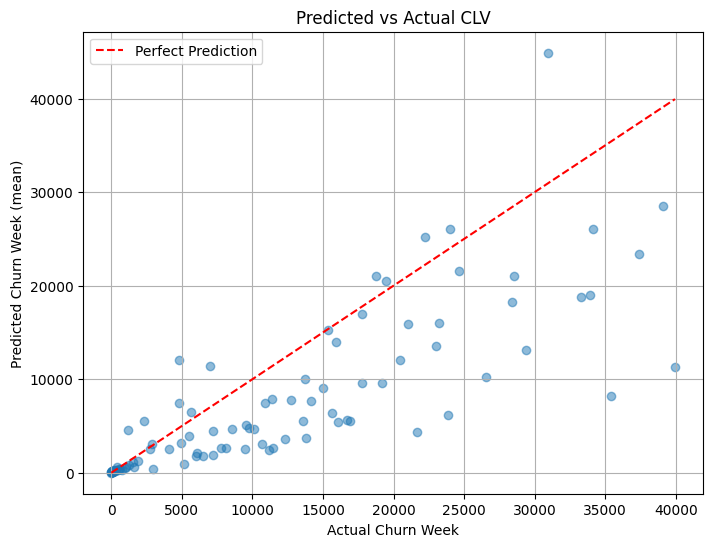

In [22]:
max_val = np.max( clv_truth )
# Scatter plot
plt.figure(figsize=(8, 6))
plt.scatter( clv_truth, expected_clv, alpha=0.5 )
plt.plot([0, max_val], [0, max_val], 'r--', label="Perfect Prediction")
plt.xlabel("Actual Churn Week")
plt.ylabel("Predicted Churn Week (mean)")
plt.title("Predicted vs Actual CLV")
plt.legend()
plt.grid(True)
plt.show()

# Plot shape of Ads and Emails Effects
Compare ground truth with inferred.

[ 0.          0.61712056  0.80466472  0.81521293  0.74168436  0.61826205
  0.45752125  0.26408812  0.03966454 -0.21512341  0.74354467  1.33066523
  1.48820939  1.4687576   1.36522903  1.21180672  1.02106592  0.79763279
  0.54320921  0.25842126  0.97759766  1.53471822  1.66226238  1.61281059
  1.47928202  1.29585971  1.07511891  0.82168578  0.5372622   0.22247425
  1.00525552  1.53237608  1.62992023  1.55046845  1.38693988  1.17351757
  0.92277677  0.63934364  0.32492006 -0.01986789  0.93802123  1.43514179
  1.50268595  1.39323416  1.19970559  0.95628329  0.67554248  0.36210935
  0.01768577 -0.35710218  0.81691446  1.28403502  1.32157918  1.1821274
  0.95859882  0.68517652  0.37443571  0.03100258 -0.343421   -0.74820895
  0.6570255   1.09414606  1.10169021  0.93223843  0.67870986  0.37528755
  0.03454675 -0.33888638 -0.74330997 -1.17809791  0.46390574  0.8710263
  0.84857046  0.64911867  0.3655901   0.03216779 -0.33857301 -0.74200614
 -1.17642972 -1.64121767  0.23959744  0.616718    0.5

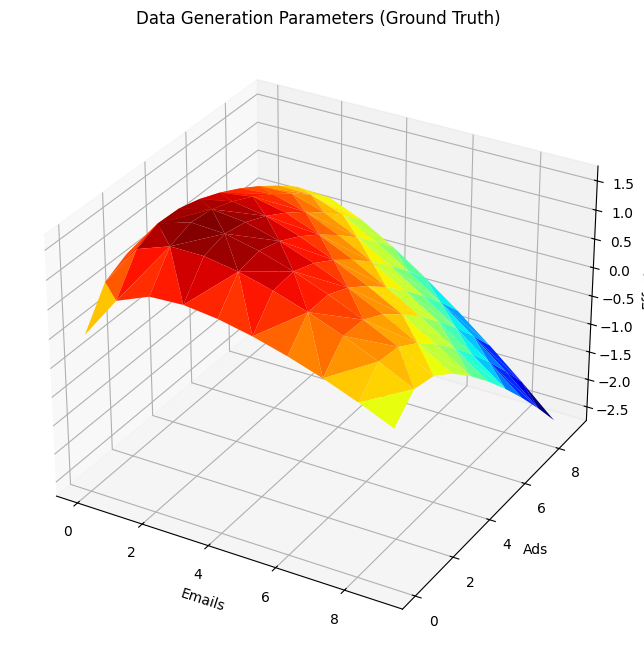

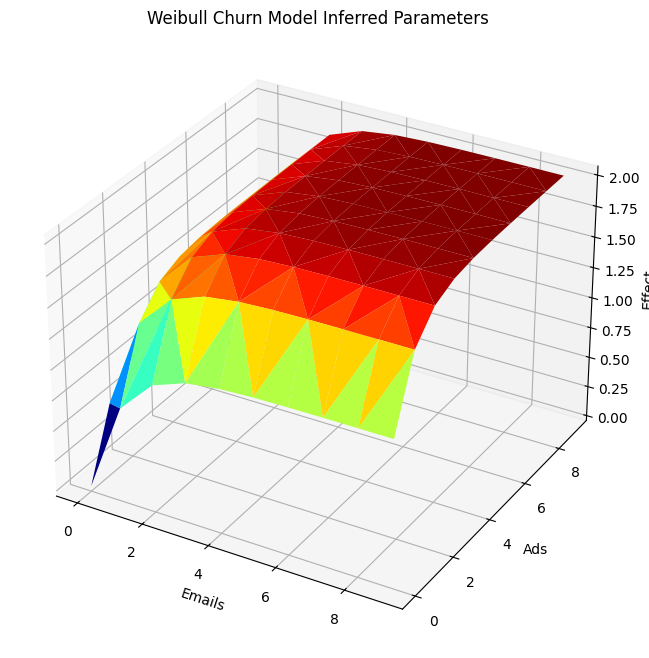

In [164]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import cm


#
def compute_effectiveness( carry_emails, carry_ads, gamma_e, gamma_a, delta ):
    total_exposure = carry_emails + carry_ads
    ret = gamma_e * (1 - np.exp(-carry_emails)) + \
            gamma_a * (1 - np.exp(-carry_ads)) + \
                -1.0 * delta * total_exposure**2
    return ret

emails_array = []
ads_array    = []
for idx in range(0,10):
    for jdx in range(0,10):
        emails_array.append(idx)
        ads_array.append(jdx)

np_emails = np.array(emails_array)
np_ads = np.array(ads_array)
gamma_e = 1.2
gamma_a = 1.0
delta   = 0.015
Z = compute_effectiveness( np_emails, np_ads, gamma_e, gamma_a, delta )
print( Z )


#
# pull from weibull model
#
'''
                            mean       std    median      5.0%     95.0%     n_eff     r_hat
              ad_decay      0.15      0.09      0.14      0.02      0.29   1827.98      1.00
             ad_effect      0.08      0.01      0.08      0.07      0.10   1716.24      1.00
       alpha_ad_effect      0.87      0.73      0.75     -0.23      1.94   1034.59      1.00
           alpha_delta      0.01      0.01      0.01      0.00      0.02   1903.87      1.00
  alpha_demo_effect[0]      0.34      0.87      0.34     -1.11      1.72   3496.56      1.00
  alpha_demo_effect[1]      0.36      0.87      0.37     -0.99      1.83   2937.95      1.00
    alpha_email_effect      1.16      0.70      1.13     -0.01      2.24   1993.62      1.00
       alpha_intercept      0.71      0.85      0.70     -0.67      2.07   2674.13      1.00
alpha_region_effect[0]      0.27      0.89      0.26     -1.30      1.66   3340.26      1.00
alpha_region_effect[1]     -0.13      0.94     -0.15     -1.69      1.42   2610.87      1.00
alpha_region_effect[2]      0.55      0.86      0.54     -0.91      1.91   2868.62      1.00
                 delta      0.00      0.00      0.00      0.00      0.00   1602.36      1.00
        demo_effect[0]     -0.07      0.22     -0.07     -0.43      0.31    895.53      1.00
        demo_effect[1]     -0.10      0.22     -0.10     -0.45      0.29    922.76      1.00
           email_decay      0.24      0.13      0.23      0.03      0.43   1696.47      1.00
          email_effect      0.07      0.01      0.07      0.05      0.09   1572.39      1.00
      region_effect[0]     -0.11      0.22     -0.11     -0.48      0.25    929.71      1.00
      region_effect[1]      0.08      0.22      0.08     -0.28      0.45    881.37      1.01
      region_effect[2]     -0.04      0.22     -0.04     -0.40      0.33    940.68      1.00                 
'''

gamma_e_model = 1.16
gamma_a_model = 0.87
delta_model   = 0.0

# 
fig = plt.figure( figsize=(8,8) )
#
#fig, axs = plt.subplots( 1, 2,
#                         figsize=(5,5) )

# ax = fig.add_subplot(111, projection='3d')
ax = fig.add_subplot(111, projection='3d')
# ax = axs[0]
X, Y = np.meshgrid( np_emails, np_ads )
# ax.plot_surface( X, Y, Z )
ax.plot_trisurf(np_emails, np_ads, Z, cmap=cm.jet, linewidth=0.2)
ax.set_title("Data Generation Parameters (Ground Truth)")
ax.set_xlabel( "Emails" )
ax.set_ylabel( "Ads" )
ax.set_zlabel( "Effect" )
plt.savefig( "Output/gt_3d_advertising_effect.png" ) 
plt.show()
plt.close()

#
#
#
Z_inferred = compute_effectiveness( np_emails, np_ads, gamma_e_model, gamma_a_model, delta_model )

#fig = plt.figure()
fig = plt.figure( figsize=(8,8) )
ax = fig.add_subplot(111, projection='3d')
# ax = axs[1]
X, Y = np.meshgrid( np_emails, np_ads )
# ax.plot_surface( X, Y, Z )
ax.plot_trisurf(np_emails, np_ads, Z_inferred, cmap=cm.jet, linewidth=0.2)
ax.set_title( "Weibull Churn Model Inferred Parameters" )
ax.set_xlabel( "Emails" )
ax.set_ylabel( "Ads" )
ax.set_zlabel( "Effect" )
plt.savefig( "Output/model_3d_advertising_effect.png" )
plt.show()
 